<a href="https://colab.research.google.com/github/m-volnykh/BasisOfMachineLearning/blob/main/LR03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №3: Временные ряды

Выполнила Вольных М.В., 3 курс ИВТ, 2-1

## Подключение данных

In [ ]:
%%capture
!git clone https://github.com/m-volnykh/BasisOfMachineLearning

In [ ]:
#импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot
import statsmodels.api as sm

from datetime import datetime

In [ ]:
data = pd.read_csv('/content/BasisOfMachineLearning/Lab3/tovar_moving.csv',
                   index_col=['date'], parse_dates=['date'], dayfirst=False)
data = data.asfreq('D')

data.head()

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0


Проверка на пропуски

In [ ]:
data.isnull().sum().sum()

np.int64(0)

## Работа с датасетом

### 1. Выделение тренировочных и тестовых данных

In [ ]:
#X - матрица наблюдений, y - столбец правильных ответов

train = data[:-1]
test = data.iloc[-1]

### 2. Анализ временного ряда на наличие тренда и сезонности

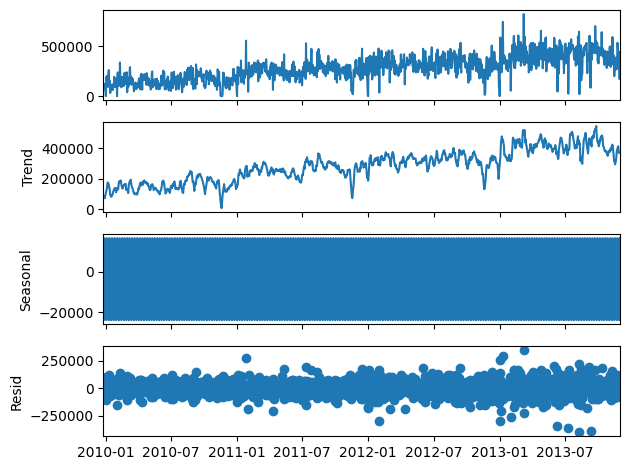

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data, model='additive')
decomposition.plot()
pyplot.show()

### 3. Прогноз с помощью экспоненциального сглаживания при α = 0.7

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(train)
model_fit = model.fit(smoothing_level=0.7, optimized=False)

# Прогнозируем следующее значение (последнее значение в тестовой выборке)
forecast = model_fit.predict(start=len(train), end=len(train))

print("Прогноз с использованием экспоненциального сглаживания (альфа=0.7):")
print(round(forecast.iloc[0],1))
print("Реальное значение:")
print(test['qty'])

Прогноз с использованием экспоненциального сглаживания (альфа=0.7):
225015.5
Реальное значение:
423846.0


### 4. Проверка ряда на стационарность

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data['qty'])

diff = 0
if adf_test[1] <= 0.05:
    print(f"Ряд стационарен\nПорядок интегрирования равен {diff}")

else:
    while adf_test[1] > 0.05 and diff != 3:
        diff += 1
        data_diff = data.diff(periods=diff).dropna()
        adf_test = adfuller(data_diff['qty'])

    if diff != 4:
        print(f'Ряд стационарен\nПорядок интегрирования равен {diff}')

    else:
        print("Ряд нестационарен")

Ряд стационарен
Порядок интегрирования равен 1


### 5. Порядок модели AR

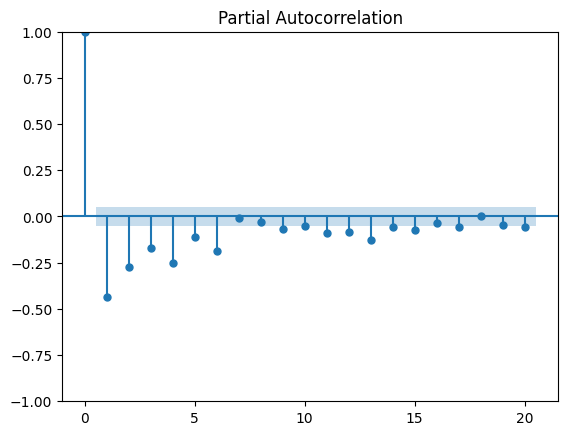

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data_diff['qty'], lags=20)
pyplot.show()

p = 7

### 6. Прогноз с помощью модели AR при p = 7

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

p = 7
model_arima = ARIMA(train['qty'], order=(p, diff, 0))
model_arima_fit = model_arima.fit()

forecast_arima = model_arima_fit.predict(start=len(train), end=len(train))

print("Прогноз с использованием модели AR:")
print(round(forecast_arima.iloc[0], 1))
print("Реальное значение:")
print(test['qty'])

Прогноз с использованием модели AR:
353079.4
Реальное значение:
423846.0


### 7. Сравнение результатов


Модель экспоненциального сглаживания прогнозировала значение *225015.5*

Модель AR прогнозировала значение *353079.4*

Настоящее же значение равно *423846.0*

Таким образом, ни одна из моделей не смогла корректно спрогнозировать значение, однако *больше приблизилась модель AR*.

Возможно такой результат связан с нетипичностью тестового примера. Нельзя однозначно оценить качество предсказаний, поскольку тестовое значение было всего одно.